In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import the necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv


# **Data Loading and Inspection**

In [28]:
path = "../input/planet/"
os.listdir(path)

['sample_submission.csv', 'test-jpg', 'train_classes.csv', 'train-jpg']

In [31]:
# loading the image datasets
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

In [32]:
# load the training set
train_df = pd.read_csv(train_path)
print(train_df.shape)
train_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [33]:
# load the test set
test_df = pd.read_csv(test_path)
print(test_df.shape)
test_df.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


# **Exploratory Data Analysis**

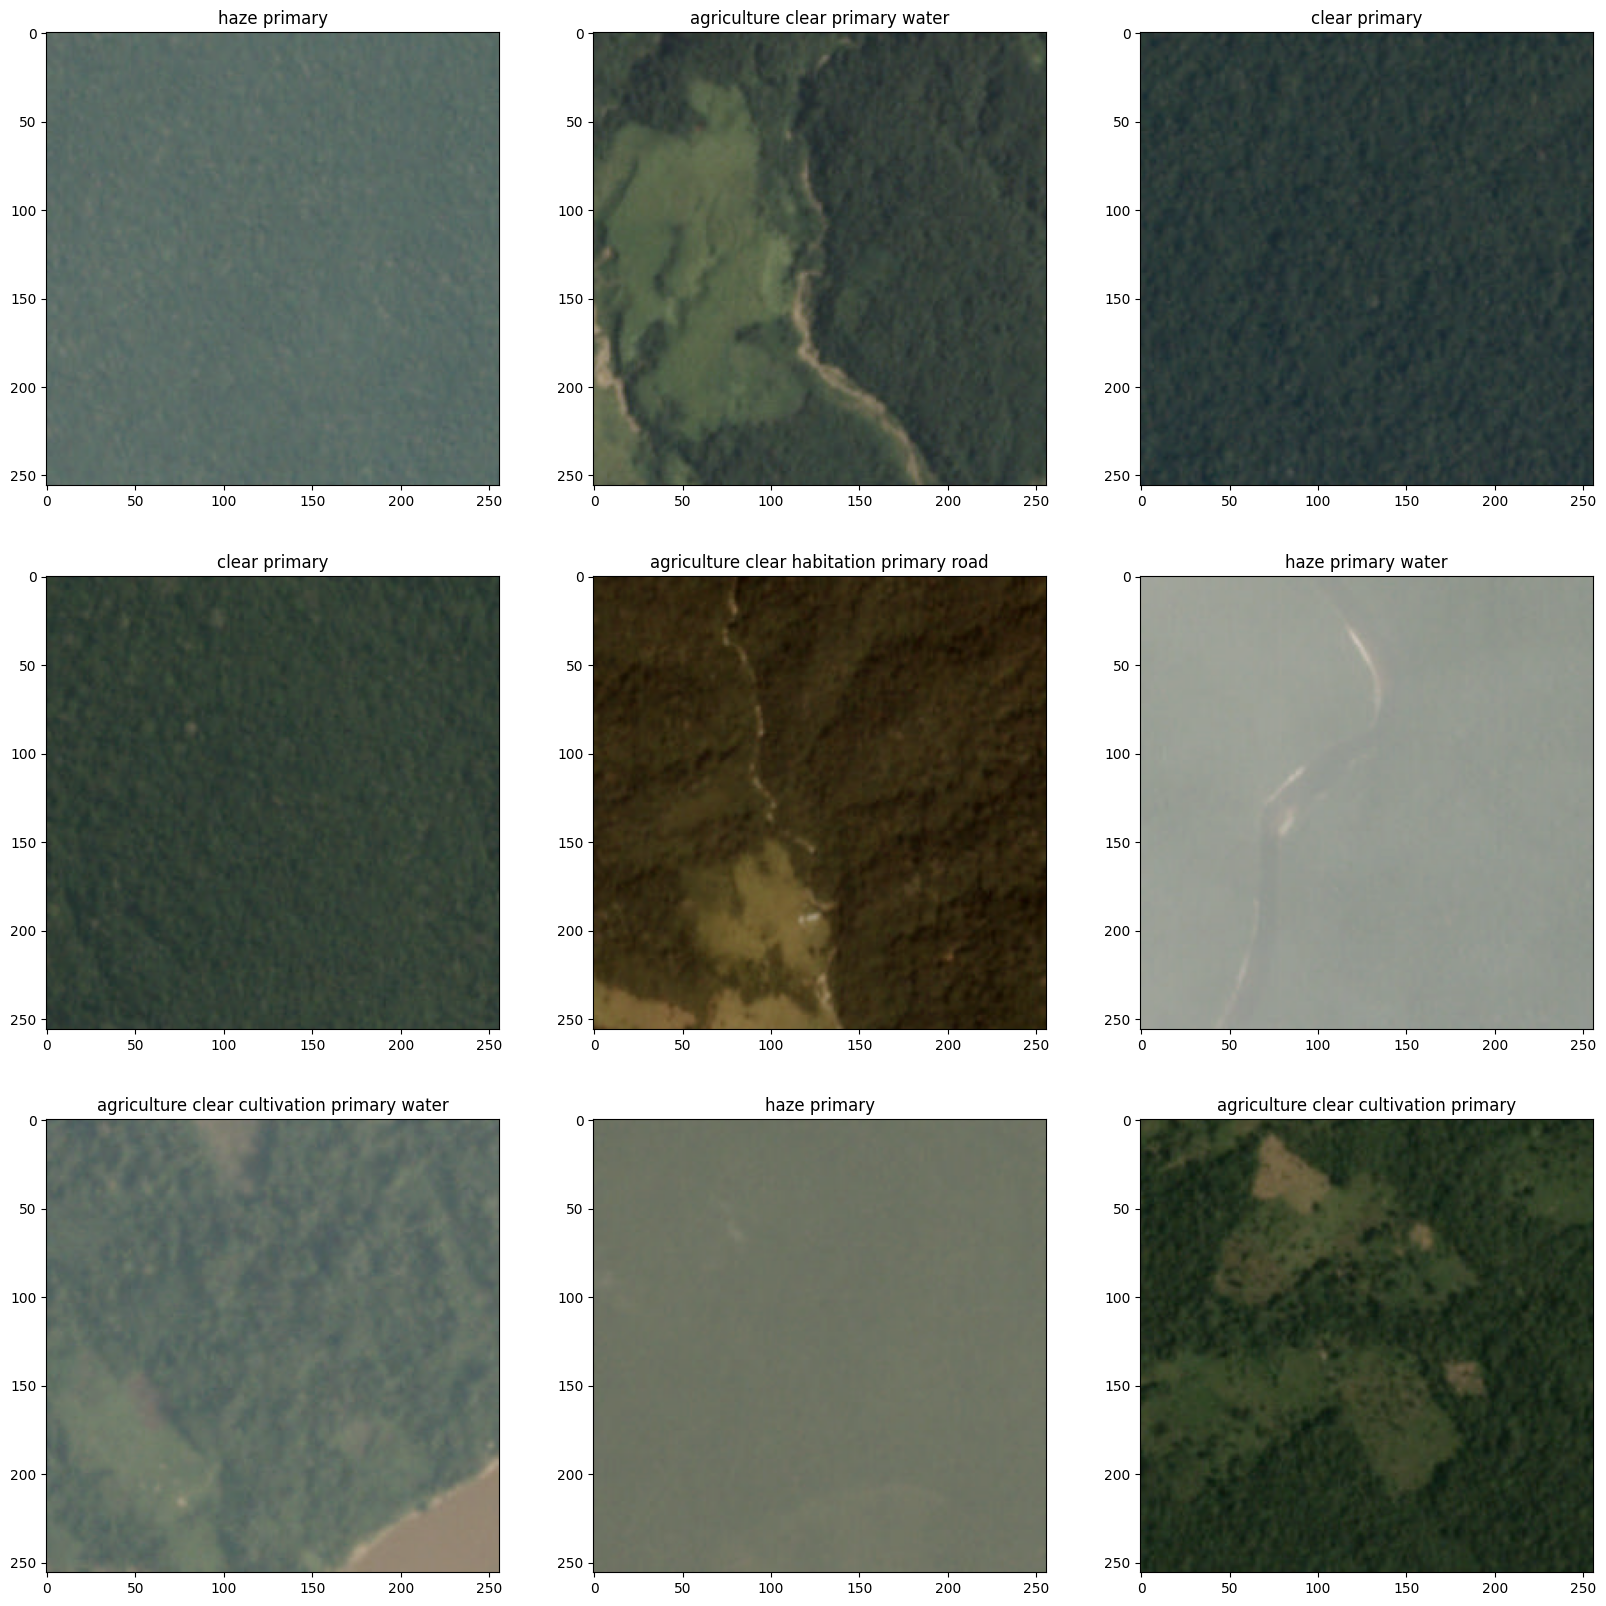

In [38]:
# let's take a look at some images
plt.figure(figsize=(20,20))
# define location of the dataset
folder = train_images
# plot the first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
    # add label on top of each image
    plt.title(f"{train_df['tags'][i]}")
# show the figure
plt.show()

In [39]:
# number of images in the training set
print(f'Number of images: {train_df.shape[0]}')

Number of images: 40479


In [40]:
# number of unique classes in the train dataset
train_df['tags'].nunique()

449

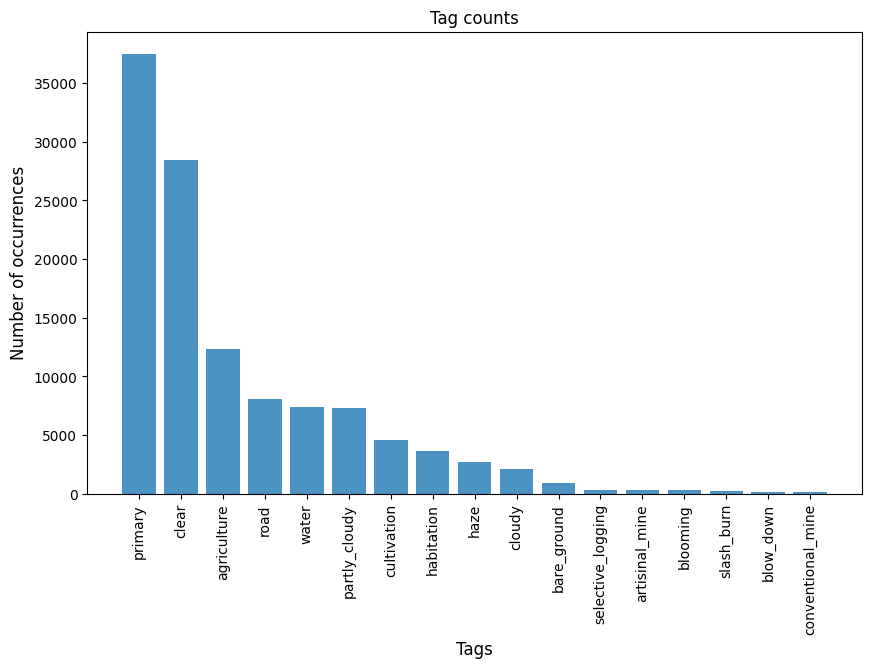

In [41]:
# tags present in the training set
tags = train_df['tags'].apply(lambda x: x.split(' '))
tags = [item for sublist in tags for item in sublist]
tag_counts = pd.Series(tags).value_counts()

# plot the tags
plt.figure(figsize=(10,6))
plt.bar(tag_counts.index, tag_counts.values, alpha=0.8)
plt.title('Tag counts')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# **Preprocessing**

In [44]:
# using set() for storing only the unique tags
labels = set()
def split_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# create a copy of `train_df`
train_df_copy = train_df.copy()
train_df_copy['tags'].apply(split_tags)
labels = list(labels)
print(labels)

['selective_logging', 'cloudy', 'agriculture', 'clear', 'artisinal_mine', 'haze', 'road', 'cultivation', 'bare_ground', 'blooming', 'slash_burn', 'blow_down', 'water', 'conventional_mine', 'primary', 'partly_cloudy', 'habitation']


In [45]:
# one hot encoding is performed on the labels in train classes 
for tag in labels:
    train_df_copy[tag] = train_df_copy['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding .jpg extension to the column image_name so as to have same name format as the image files
train_df_copy['image_name'] = train_df_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df_copy.head()

,image_name,tags,selective_logging,cloudy,agriculture,clear,artisinal_mine,haze,road,cultivation,bare_ground,blooming,slash_burn,blow_down,water,conventional_mine,primary,partly_cloudy,habitation
0,train_0.jpg,haze primary,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,train_1.jpg,agriculture clear primary water,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0
2,train_2.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,train_3.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1


In [47]:
# define the columns
columns = list(train_df_copy.columns[2:])
columns

['selective_logging',
 'cloudy',
 'agriculture',
 'clear',
 'artisinal_mine',
 'haze',
 'road',
 'cultivation',
 'bare_ground',
 'blooming',
 'slash_burn',
 'blow_down',
 'water',
 'conventional_mine',
 'primary',
 'partly_cloudy',
 'habitation']

In [50]:
# initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df_copy,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

# generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=train_df_copy,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


# **Model Training**

In [52]:
# define the model
def cnn_model():
    model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # convoluted layers
    Flatten(),
    # fully connected layers
    Dense(units=512, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=17, activation='sigmoid')    
    ])
    
    # compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [53]:
# initialize the model
model = cnn_model()

# preview the model architectures
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [54]:
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [57]:
# setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

# fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 10, 
                    callbacks = [earlystop])

Epoch 1/10
1012/1012 [==============================] - 935s 924ms/step - loss: 0.1424 - accuracy: 0.2027 - val_loss: 0.1371 - val_accuracy: 0.1427
Epoch 2/10
1012/1012 [==============================] - 929s 917ms/step - loss: 0.1369 - accuracy: 0.2208 - val_loss: 0.1374 - val_accuracy: 0.1365
Epoch 3/10
1012/1012 [==============================] - 925s 914ms/step - loss: 0.1307 - accuracy: 0.2143 - val_loss: 0.1306 - val_accuracy: 0.1571
Epoch 4/10
1012/1012 [==============================] - 935s 924ms/step - loss: 0.1237 - accuracy: 0.2289 - val_loss: 0.1240 - val_accuracy: 0.1800
Epoch 5/10
1012/1012 [==============================] - 940s 928ms/step - loss: 0.1166 - accuracy: 0.2325 - val_loss: 0.1257 - val_accuracy: 0.1620
Epoch 6/10
1012/1012 [==============================] - 930s 919ms/step - loss: 0.1101 - accuracy: 0.2291 - val_loss: 0.1246 - val_accuracy: 0.1792
Epoch 6: early stopping


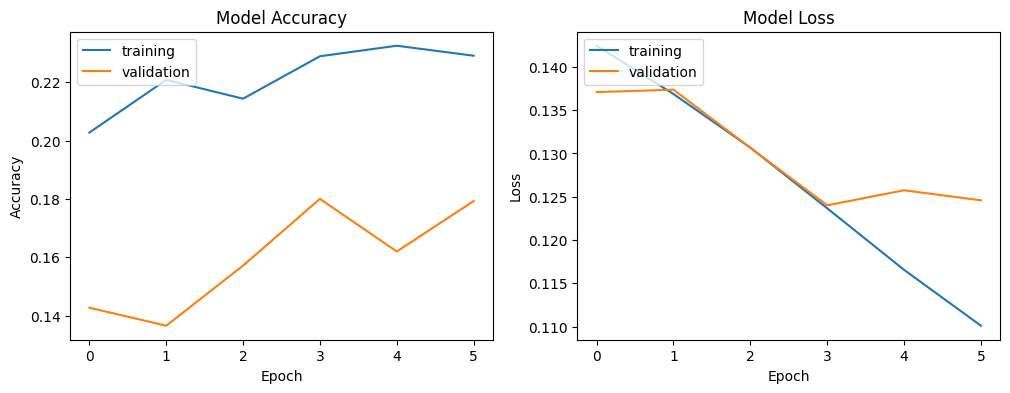

In [58]:
# plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()


In [59]:
# initializing a another model to make predictions
model1 = cnn_model()

In [60]:
# adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_copy = sample_submission.copy()
sample_submission_copy['image_name'] = sample_submission_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission_copy.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [62]:
# divide the sample submission file into two splits,
# first test1_df contains the first 40600 images 
test_df1 = sample_submission_copy.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [63]:
# initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

# creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40600 validated image filenames.


In [64]:
# reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model1.predict(test_gen, steps=step_test_size1, verbose=1)

# get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

1269/1269 [==============================] - 318s 250ms/step


,image_name,tags
0,test_0.jpg,selective_logging agriculture clear road culti...
1,test_1.jpg,selective_logging agriculture clear road culti...
2,test_2.jpg,selective_logging agriculture clear road culti...
3,test_3.jpg,selective_logging agriculture clear road culti...
4,test_4.jpg,selective_logging agriculture clear road culti...


In [66]:
#second batch of the test dataset
additional_df = sample_submission_copy.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,test_40600.jpg
1,test_40601.jpg
2,test_40602.jpg
3,test_40603.jpg
4,test_40604.jpg


In [67]:
# creating a generator for the second batch of test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 20522 validated image filenames.


In [68]:
# reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model1.predict(test_gen1, steps = step_test_size2, verbose = 1)

# get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

# convert the predicted values to a dataframe
# join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

642/642 [==============================] - 158s 245ms/step


,image_name,tags
0,file_0.jpg,selective_loggingagricultureclearroadcultivati...
1,file_1.jpg,selective_loggingagricultureclearcultivationba...
2,file_10.jpg,selective_loggingagricultureclearroadcultivati...
3,file_100.jpg,selective_loggingagricultureclearroadcultivati...
4,file_1000.jpg,selective_loggingagricultureclearroadcultivati...


In [69]:
# final result of the predicted tags for the test images,
# concat the first and second results in that order to avoid shuffling the index
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61122, 2)


,image_name,tags
0,test_0.jpg,selective_logging agriculture clear road culti...
1,test_1.jpg,selective_logging agriculture clear road culti...
2,test_2.jpg,selective_logging agriculture clear road culti...
3,test_3.jpg,selective_logging agriculture clear road culti...
4,test_4.jpg,selective_logging agriculture clear road culti...


In [70]:
# remove the .jpg extension from the image_name of the last_result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,selective_logging agriculture clear road culti...
1,test_1,selective_logging agriculture clear road culti...
2,test_2,selective_logging agriculture clear road culti...
3,test_3,selective_logging agriculture clear road culti...
4,test_4,selective_logging agriculture clear road culti...


In [71]:
# finally, we save the result to a csv file using the .to_csv() method and setting the index to false.
final_df.to_csv('submission.csv', index = False)